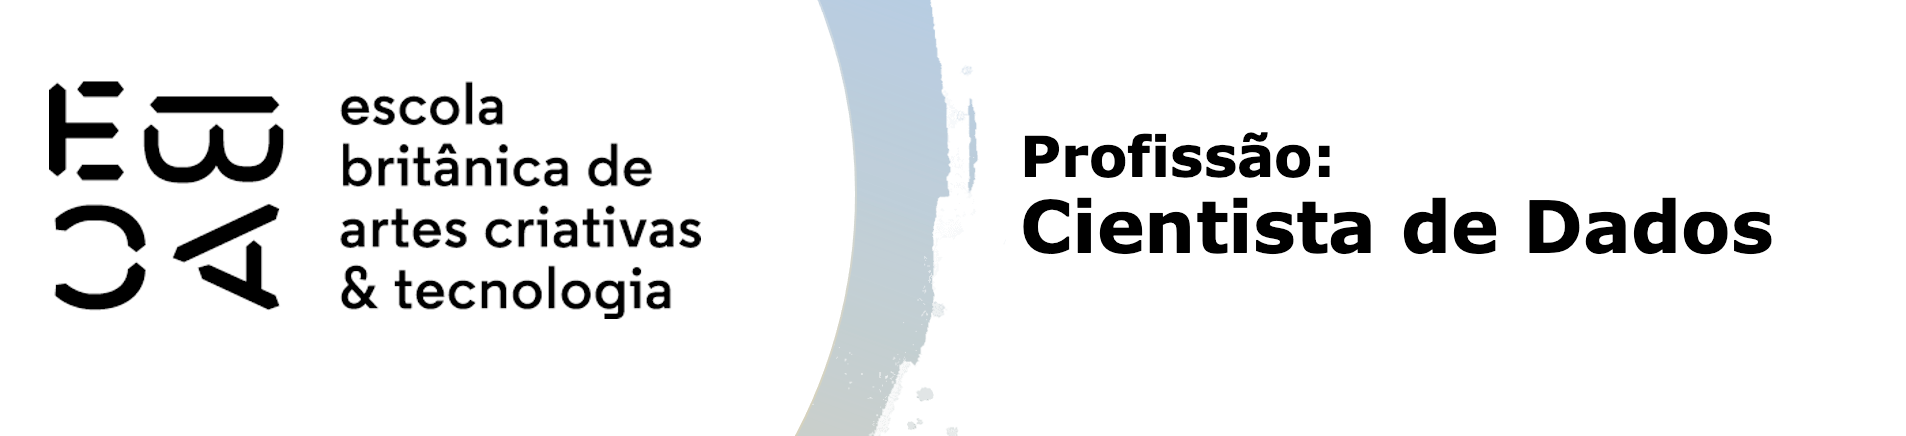

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.9


In [2]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -p numpy,pandas,matplotlib,seaborn,scipy,gower,sklearn

numpy     : 1.23.5
pandas    : 1.5.3
matplotlib: 3.7.0
seaborn   : 0.12.2
scipy     : 1.10.0
gower     : 0.1.2
sklearn   : 1.2.1



In [4]:
# Carregando dataset
df = pd.read_csv('online_shoppers_intention.csv')

In [5]:
# Amostra de dados
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
# Valores únicos da coluna "Revenue" incluindo os valores ausentes caso eles existam
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [7]:
# Shape
df.shape

(12330, 18)

In [8]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [9]:
# Descrevendo os dados não numéricos
df.describe(include = object)

,Month,VisitorType
count,12330,12330
unique,10,3
top,May,Returning_Visitor
freq,3364,10551


### Visualizando as Variáveis Categóricas

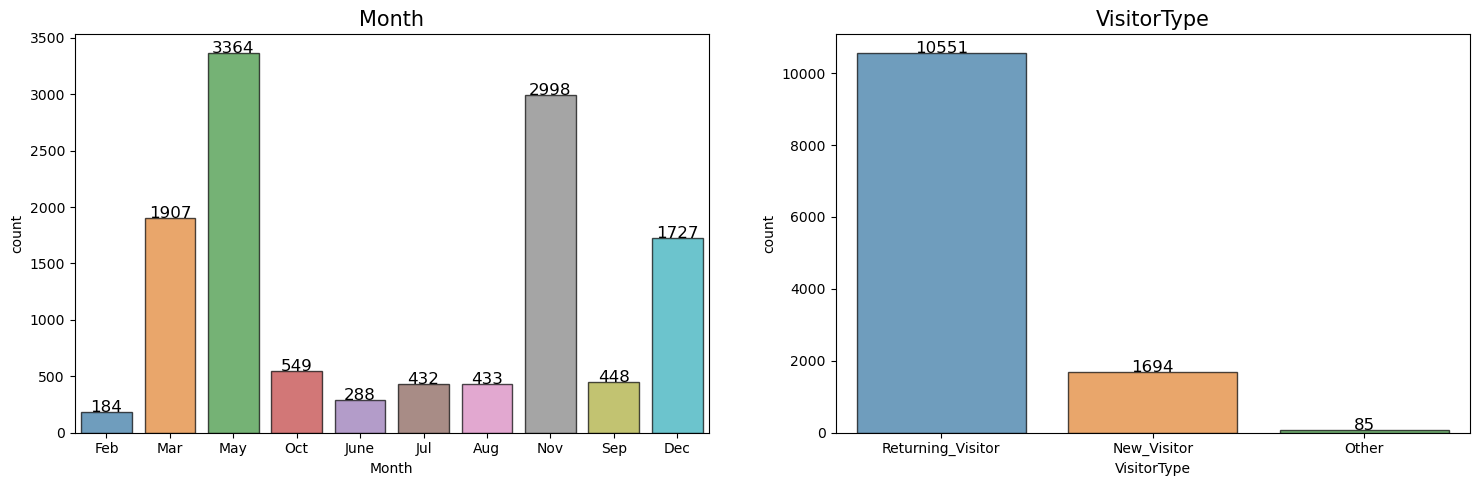

In [8]:
# Tamanho da figura
plt.figure(figsize = (18,30))

# Lista de colunas
column_list = df[['Month', 'VisitorType']]

# Contador
A = 0

# Loop
for i in column_list:
    A += 1
    plt.subplot(5, 2, A)
    ax = sns.countplot(data = df.fillna('NaN'), alpha = 0.7, edgecolor='black', x = i)
    plt.title(i, fontsize = 15)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)
    if A >= 7:
        plt.xticks(rotation = 45)

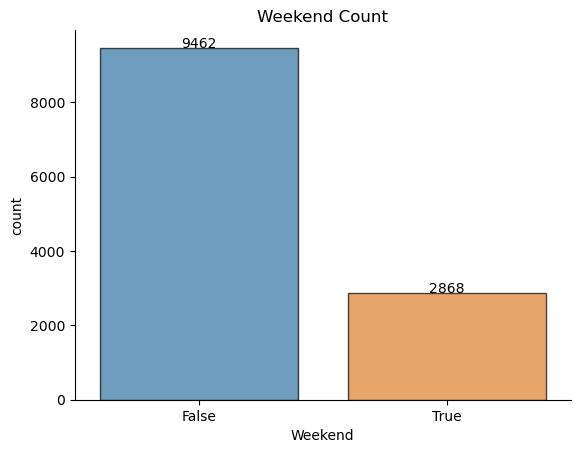

In [9]:
# Visualizando a distribuição de frequências dos valores da coluna Weekend
sns.countplot(data=df, x = 'Weekend', alpha = 0.7, edgecolor = 'black').set_title("Weekend Count")
sns.despine()
plt.xticks()
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)

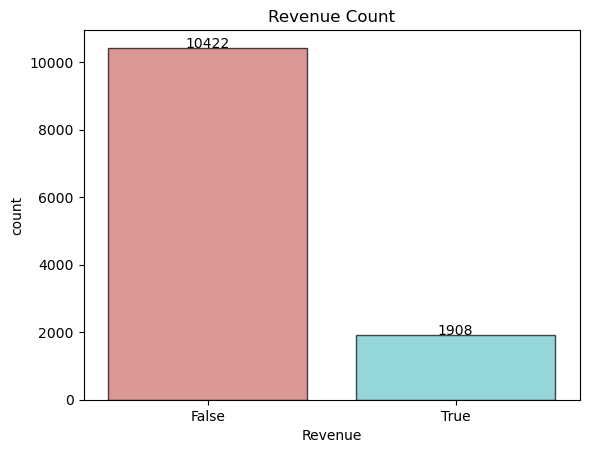

In [10]:
# Visualizando a distribuição de frequências dos valores da coluna Revenue
sns.countplot(data=df, x = 'Revenue', alpha = 0.7, edgecolor = 'black', palette='hls').set_title("Revenue Count")
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)

### Verificando a Distribuição das Variáveis Numéricas

In [11]:
# Descrevendo os dados numéricos
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [12]:
# Valores únicos de cada variável
df.nunique(axis=0)

Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

Text(0.5, 1.0, 'ProductRelated_Duration Count')

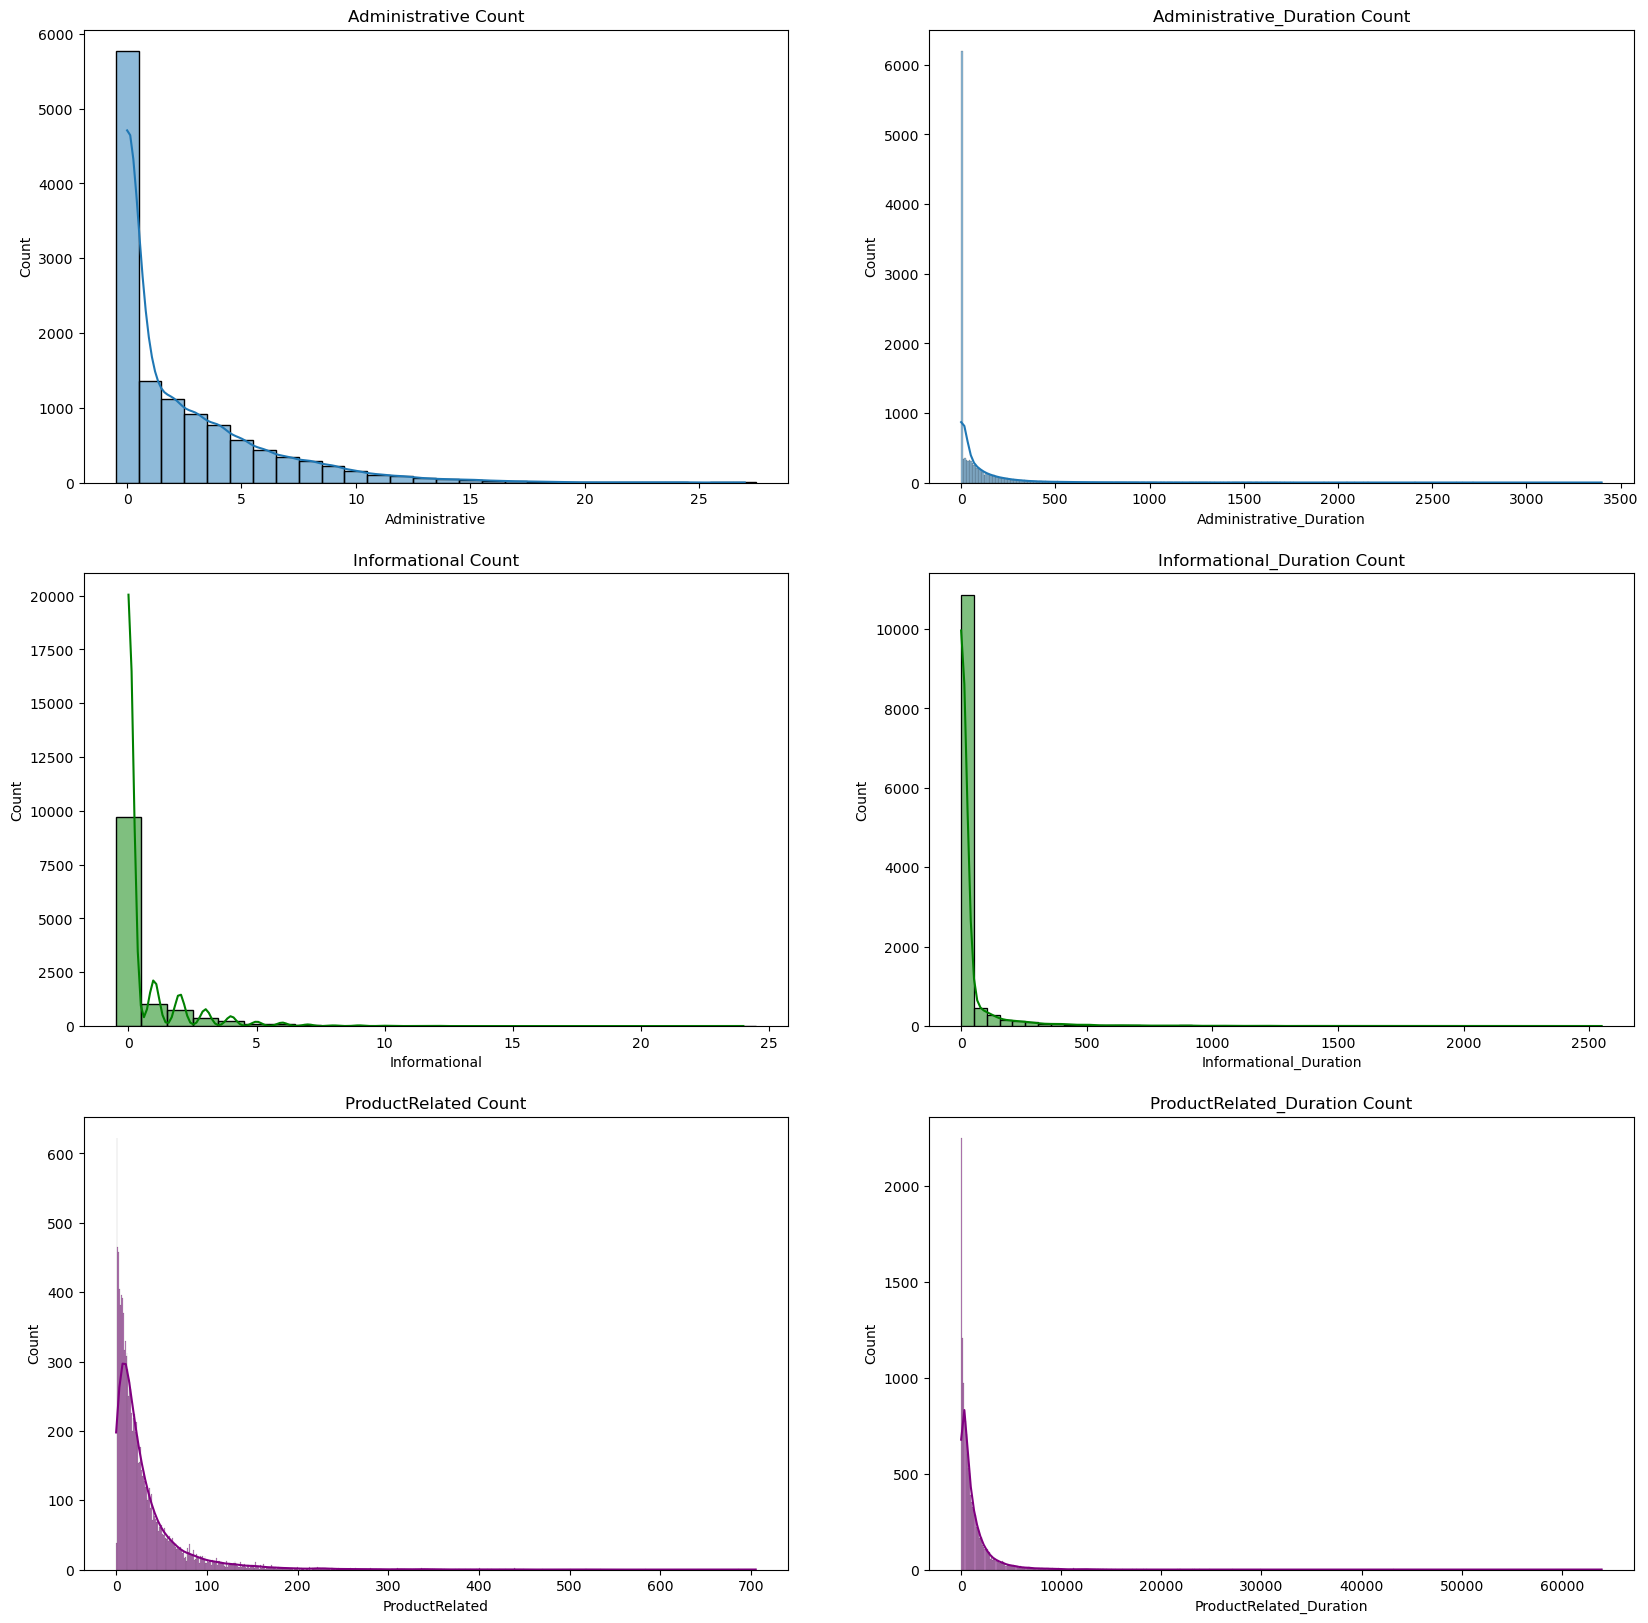

In [13]:
# Figura
fig, axis = plt.subplots(3, 2, figsize=(20,20))
sns.color_palette("hls", 8)

# Subplots com histogramas
sns.histplot(data=df, x = "Administrative", discrete=True, kde = True, ax=axis[0,0])
axis[0, 0].set_title("Administrative Count")

sns.histplot(data=df, x = "Administrative_Duration", kde = True, ax=axis[0,1])
axis[0, 1].set_title("Administrative_Duration Count")

sns.histplot(data=df, x = "Informational", discrete=True, kde = True, color='green', ax=axis[1,0])
axis[1, 0].set_title("Informational Count")

sns.histplot(data=df, x = "Informational_Duration", bins=50, kde = True, color='green', ax=axis[1,1])
axis[1, 1].set_title("Informational_Duration Count")

sns.histplot(data=df, x = "ProductRelated", discrete=True, kde = True, color='purple', ax=axis[2,0])
axis[2, 0].set_title("ProductRelated Count")

sns.histplot(data=df, x = "ProductRelated_Duration", kde = True, color='purple', ax=axis[2,1])
axis[2, 1].set_title("ProductRelated_Duration Count")



Text(0.5, 1.0, 'SpecialDay Count')

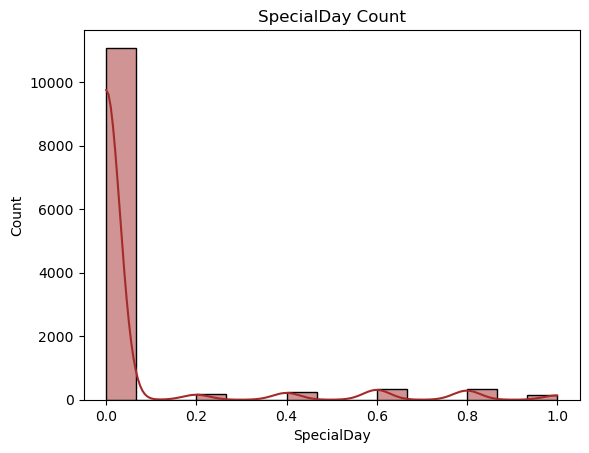

In [14]:
ax = sns.histplot(data=df, x = "SpecialDay",kde = True, color='brown')
ax.set_title("SpecialDay Count")

In [15]:
# Verificando valores missing em cada coluna
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [16]:
# Variáveis que vamos utilizar
variaveis = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
             'SpecialDay', 'Month', 'Weekend']
variaveis_qtd = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']
variaveis_cat = ['SpecialDay', 'Month', 'Weekend']

In [17]:
# Padronizando
df_pad = pd.DataFrame(StandardScaler().fit_transform(df[variaveis_qtd]), columns = df[variaveis_qtd].columns)

In [18]:
df_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430


In [19]:
# Atribuindo o conteúdo do dataframe original no dataframe padronizado
df_pad[variaveis_cat] = df[variaveis_cat]

In [20]:
#Transformando em dummies
df2 = pd.get_dummies(df_pad[variaveis].dropna(), columns=variaveis_cat)
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay_0.0,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Weekend_False,Weekend_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


 - Obtemos um dataframe com valores quantitativos padronizados e valores categóricos como Dummies

In [21]:
# Colunas
df2.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'SpecialDay_0.0', 'SpecialDay_0.2', 'SpecialDay_0.4', 'SpecialDay_0.6',
       'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'Weekend_False', 'Weekend_True'],
      dtype='object')

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [22]:
vars_cat = [True if x in {'SpecialDay_0.0', 'SpecialDay_0.2',
       'SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8',
       'SpecialDay_1.0', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'Weekend_False', 'Weekend_True'} else False for x in df2.columns]

In [23]:
#Shape
df2.shape

(12330, 24)

In [24]:
%%time

# calculando as distâncias
distancia_gower = gower_matrix(df2, cat_features=vars_cat)

# ajustando a matriz de distâncias para alimentar o algoritmo com este objeto
gdv = squareform(distancia_gower, force='tovector')

Wall time: 43.8 s


In [25]:
# Shape
gdv.shape

(76008285,)

In [26]:
# Fazendo o agrupamento
Z = linkage(gdv, method='complete')

### Agrupamentos hierárquicos com 3 grupos

In [27]:
# Classificar as observações
df2['grupos_3'] = fcluster(Z, 3, criterion='maxclust')
df2.grupos_3.value_counts()

2    6657
1    2840
3    2833
Name: grupos_3, dtype: int64

In [28]:
# Pegando a base original e fazendo um left join 
df3 = df.join(df2['grupos_3'], how='left')

In [29]:
# Substitundo os rótulos da coluna
df3['grupos_3'].replace({1:"grupo_1", 3:"grupo_3", 2:"grupo_2"}, inplace=True)

<AxesSubplot:xlabel='BounceRates', ylabel='grupos_3'>

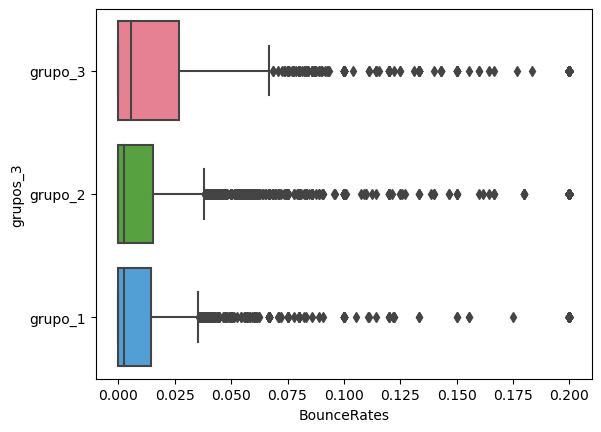

In [30]:
# Verificando variação de dados entre as colunas grupos_3 e BounceRates
sns.boxplot(data=df3, y='grupos_3', x='BounceRates', palette ='husl')

In [31]:
# Tabela cruzada entre coluna Revenue e grupos_3
pd.crosstab(df3.Revenue, df3.grupos_3)

grupos_3,grupo_1,grupo_2,grupo_3
Revenue,,,
False,2342,5516,2564
True,498,1141,269


### Agrupamentos hierárquicos com 4 grupos

In [32]:
# Classificar as observações
df2['grupos_4'] = fcluster(Z, 4, criterion='maxclust')
df2.grupos_4.value_counts()

2    6657
1    2840
3    2649
4     184
Name: grupos_4, dtype: int64

In [33]:
# Pegando a base original e fazendo um left join 
df3 = df.join(df2['grupos_4'], how='left')
# Substitundo os rótulos da coluna
df3['grupos_4'].replace({1:"grupo_1", 3:"grupo_3", 2:"grupo_2", 4:"grupo_4"}, inplace=True)

<AxesSubplot:xlabel='BounceRates', ylabel='grupos_4'>

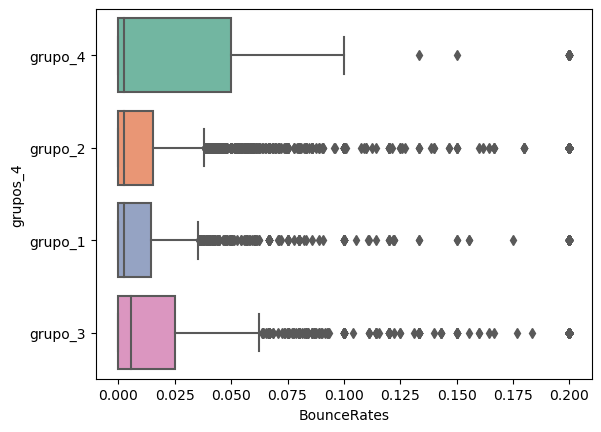

In [34]:
# Verificando variação de dados entre as colunas grupos_4 e BounceRates
sns.boxplot(data=df3, y='grupos_4', x='BounceRates', palette = 'Set2')

In [35]:
# Tabela cruzada entre as colunas Revenue e grupos_4
pd.crosstab(df3.Revenue, df3.grupos_4)

grupos_4,grupo_1,grupo_2,grupo_3,grupo_4
Revenue,,,,
False,2342,5516,2383,181
True,498,1141,266,3


## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

### Com 2 grupos

In [36]:
# Classificar as observações
df2['grupos_2'] = fcluster(Z, 2, criterion='maxclust')
df2.grupos_2.value_counts()

2    9490
1    2840
Name: grupos_2, dtype: int64

In [37]:
# Pegando a base original e fazendo um left join 
df3 = df.join(df2['grupos_2'], how='left')
# Substitundo os rótulos da coluna
df3['grupos_2'].replace({1:"grupo_1", 2:"grupo_2"}, inplace=True)

<AxesSubplot:xlabel='BounceRates', ylabel='grupos_2'>

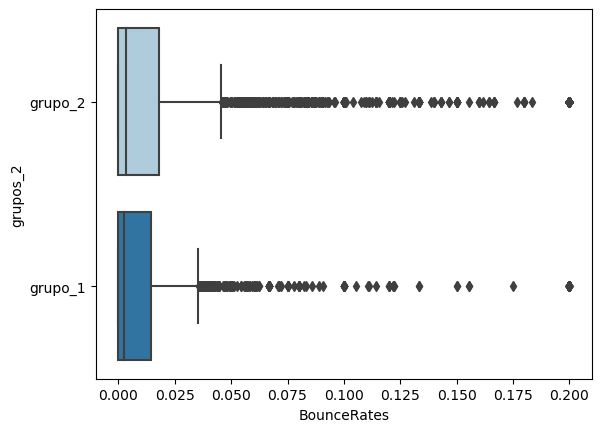

In [38]:
# Verificando variação de dados entre as colunas grupos_2 e BounceRates
sns.boxplot(data=df3, y='grupos_2', x='BounceRates', palette = 'Paired')

In [39]:
# Tabela cruzada entre as colunas Revenue e grupos_2
pd.crosstab(df3.Revenue, df3.grupos_2)

grupos_2,grupo_1,grupo_2
Revenue,,
False,2342,8080
True,498,1410


### Com 6 grupos

In [40]:
# Classificar as observações
df2['grupos_6'] = fcluster(Z, 6, criterion='maxclust')
df2.grupos_6.value_counts()

4    6655
1    2839
5    2649
6     184
3       2
2       1
Name: grupos_6, dtype: int64

In [41]:
# Pegando a base original e fazendo um left join 
df3 = df.join(df2['grupos_6'], how='left')
# Substitundo os rótulos da coluna
df3['grupos_6'].replace({1:"grupo_1", 3:"grupo_3", 2:"grupo_2", 4:"grupo_4", 5:"grupo_5", 6:"grupo_6"}, inplace=True)

<AxesSubplot:xlabel='BounceRates', ylabel='grupos_6'>

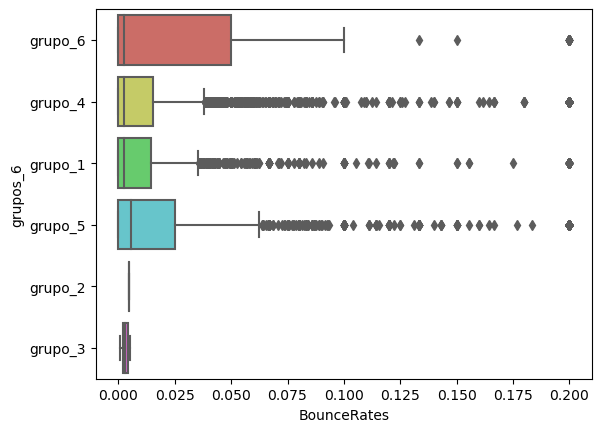

In [42]:
# Verificando variação de dados entre as colunas grupos_6 e BounceRates
sns.boxplot(data=df3, y='grupos_6', x='BounceRates', palette = 'hls')

- O grupo com 2 e 3 são os melhores entre todos os avaliados.
- Agrupamentos com 4 e 6 ficaram com poucos dados, dando a impressão de serem outliers

### Agrupamento final

In [43]:
# Classificar as observações em grupos com base na distância entre elas
df2['grupos_3'] = fcluster(Z, 3, criterion='maxclust')
# Pegando a base original e fazendo um left join 
df3 = df.join(df2['grupos_3'], how='left')
# Substitundo os rótulos da coluna
df3['grupos_3'].replace({1:"grupo_1", 3:"grupo_3", 2:"grupo_2"}, inplace=True)

In [44]:
# Tabela Cruzada entre colunas Revenue e grupos_3 normalizando os valores pela soma das colunas 
pd.crosstab(df3.Revenue, df3.grupos_3, normalize='columns')

grupos_3,grupo_1,grupo_2,grupo_3
Revenue,,,
False,0.824648,0.828601,0.905048
True,0.175352,0.171399,0.094952


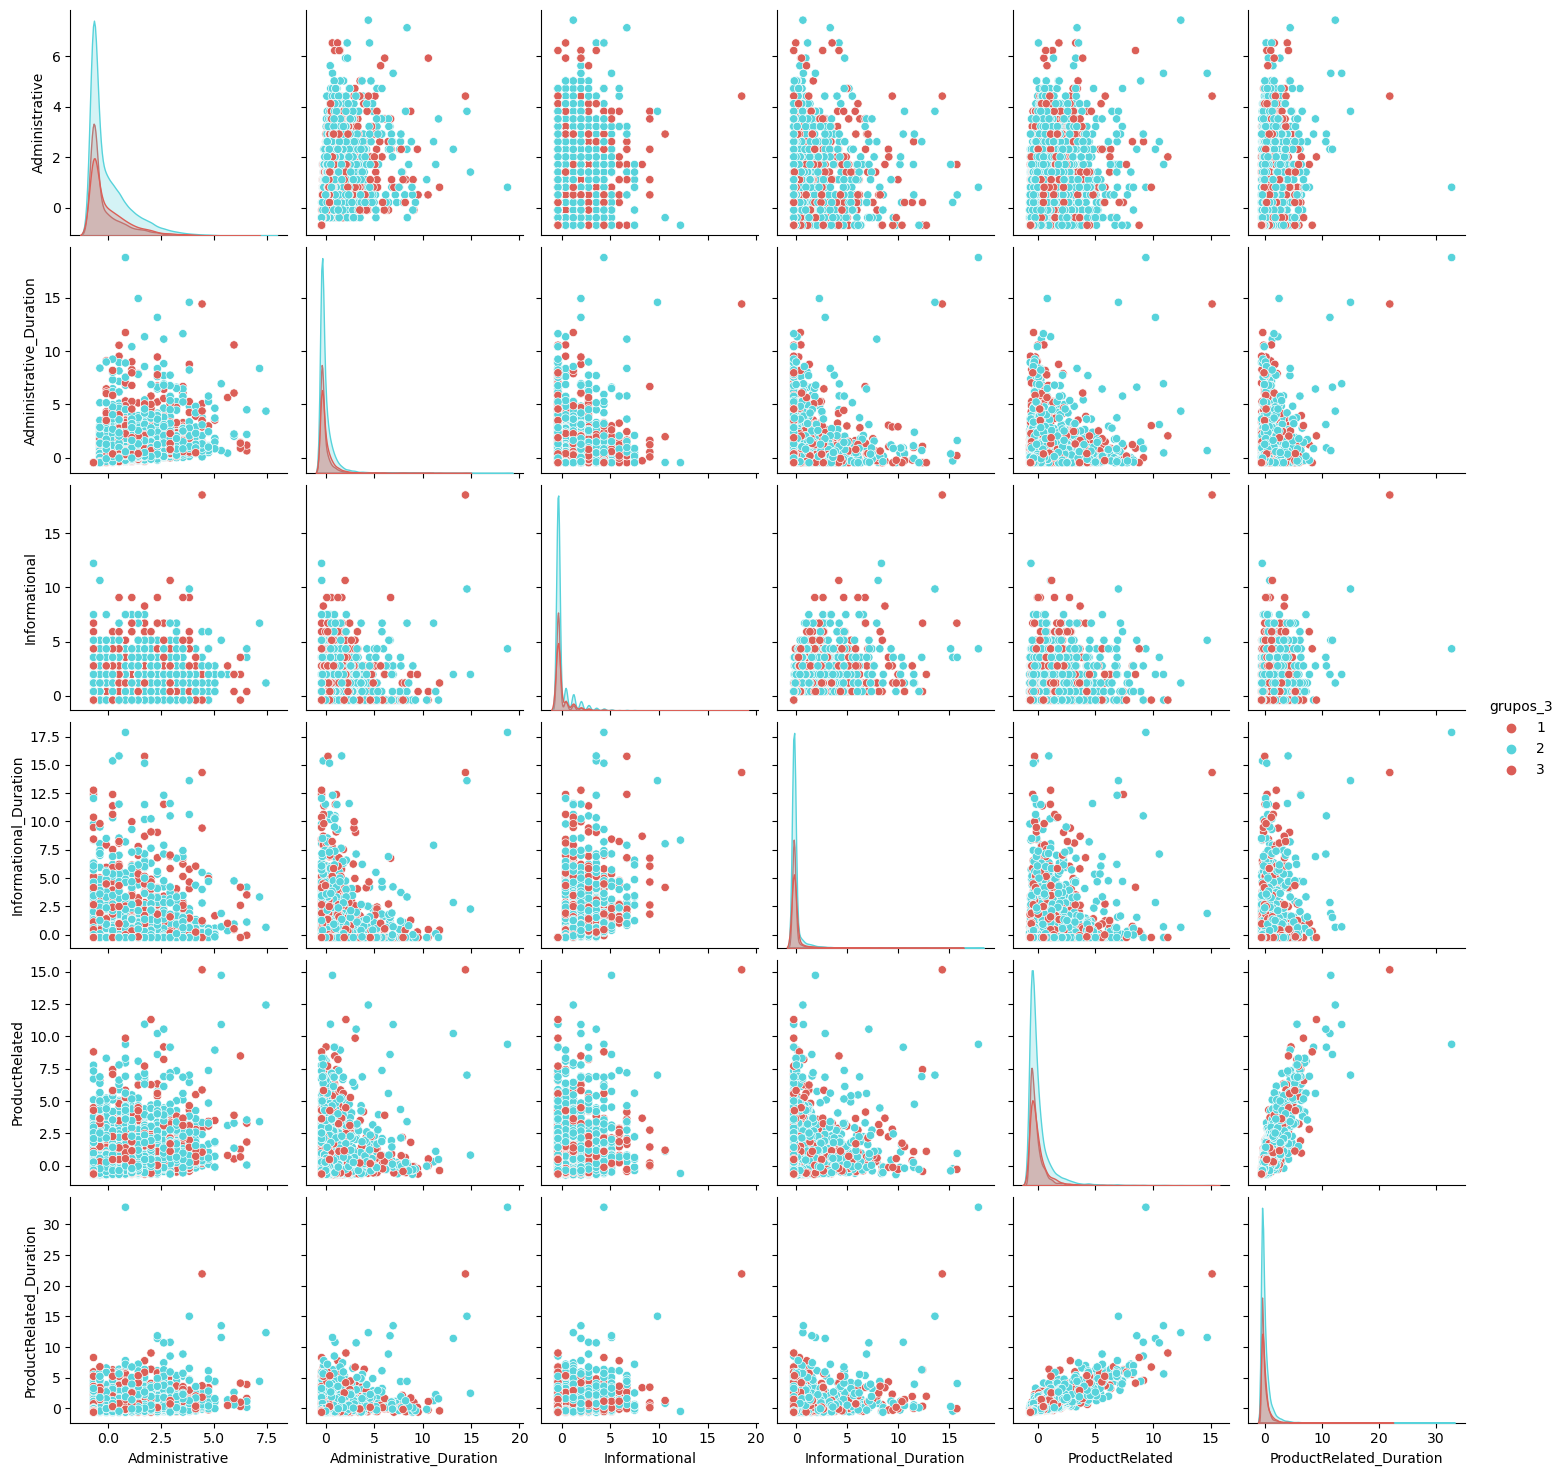

In [45]:
# Plot da relação entre as variáveis
sns.pairplot(df2[['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'grupos_3']], hue='grupos_3', palette = 'hls')

In [46]:
#fig, axis = plt.subplots(3, 1, figsize=(15,15))

#sns.countplot(data=df3, x = "SpecialDay", hue='grupos_3', ax=axis[0])
#ax = axis[0].axes
#for p in ax.patches:
    #ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)

#sns.countplot(data=df3, x = "Month", hue='grupos_3', ax=axis[1])
#ax = axis[1].axes
#for p in ax.patches:
    #ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)

#sns.countplot(data=df3, x = "Weekend", hue='grupos_3', ax=axis[2])
#ax = axis[2].axes
#for p in ax.patches:
    #ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)


<AxesSubplot:xlabel='Weekend', ylabel='count'>

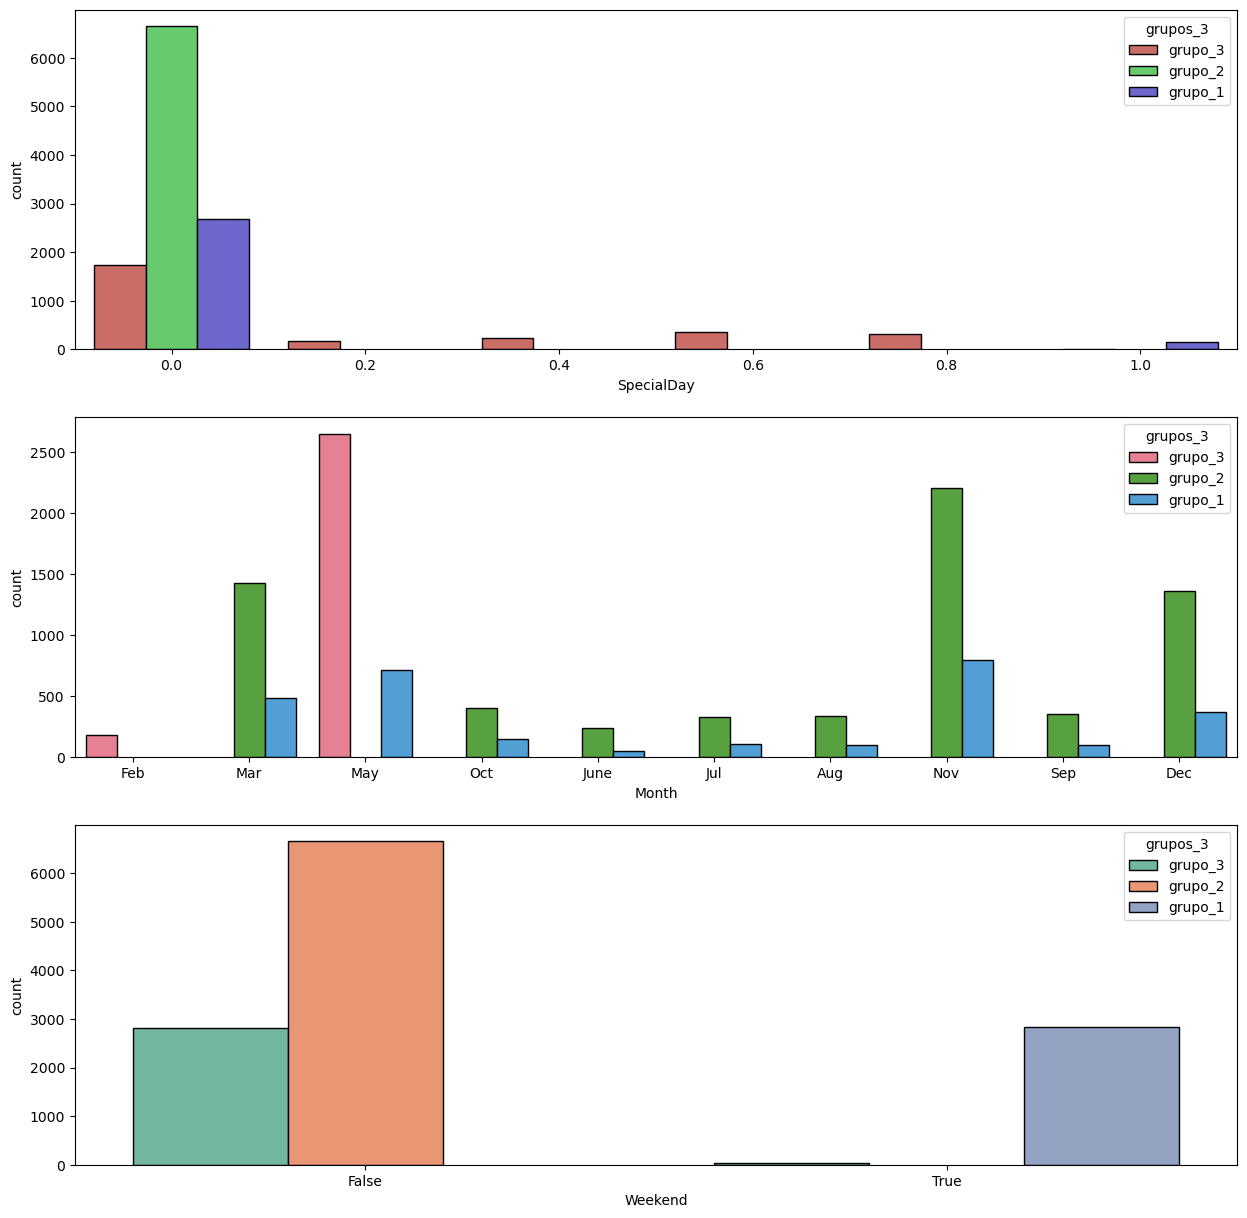

In [47]:
# Distribuição das variáveis
fig, axis = plt.subplots(3, 1, figsize=(15,15))

sns.countplot(data=df3, x = "SpecialDay", hue='grupos_3', palette ='hls', edgecolor='black', ax=axis[0])
sns.countplot(data=df3, x = "Month", hue='grupos_3', palette ='husl', edgecolor='black', ax=axis[1])
sns.countplot(data=df3, x = "Weekend", hue='grupos_3', palette ='Set2', edgecolor='black', ax=axis[2])

### Grupo 2

In [48]:
# Classificar as observações em grupos com base na distância entre elas
df2['grupos_2'] = fcluster(Z, 2, criterion='maxclust')
# Pegando a base original e fazendo um left join 
df3 = df.join(df2['grupos_2'], how='left')
# Substitundo os rótulos da coluna
df3['grupos_2'].replace({1:"grupo_1", 2:"grupo_2"}, inplace=True)

In [49]:
# Tabela cruzada entre as colunas Revenue e grupos_2
pd.crosstab(df3.Revenue, df3.grupos_2, normalize='columns')

grupos_2,grupo_1,grupo_2
Revenue,,
False,0.824648,0.851423
True,0.175352,0.148577


<AxesSubplot:xlabel='Weekend', ylabel='count'>

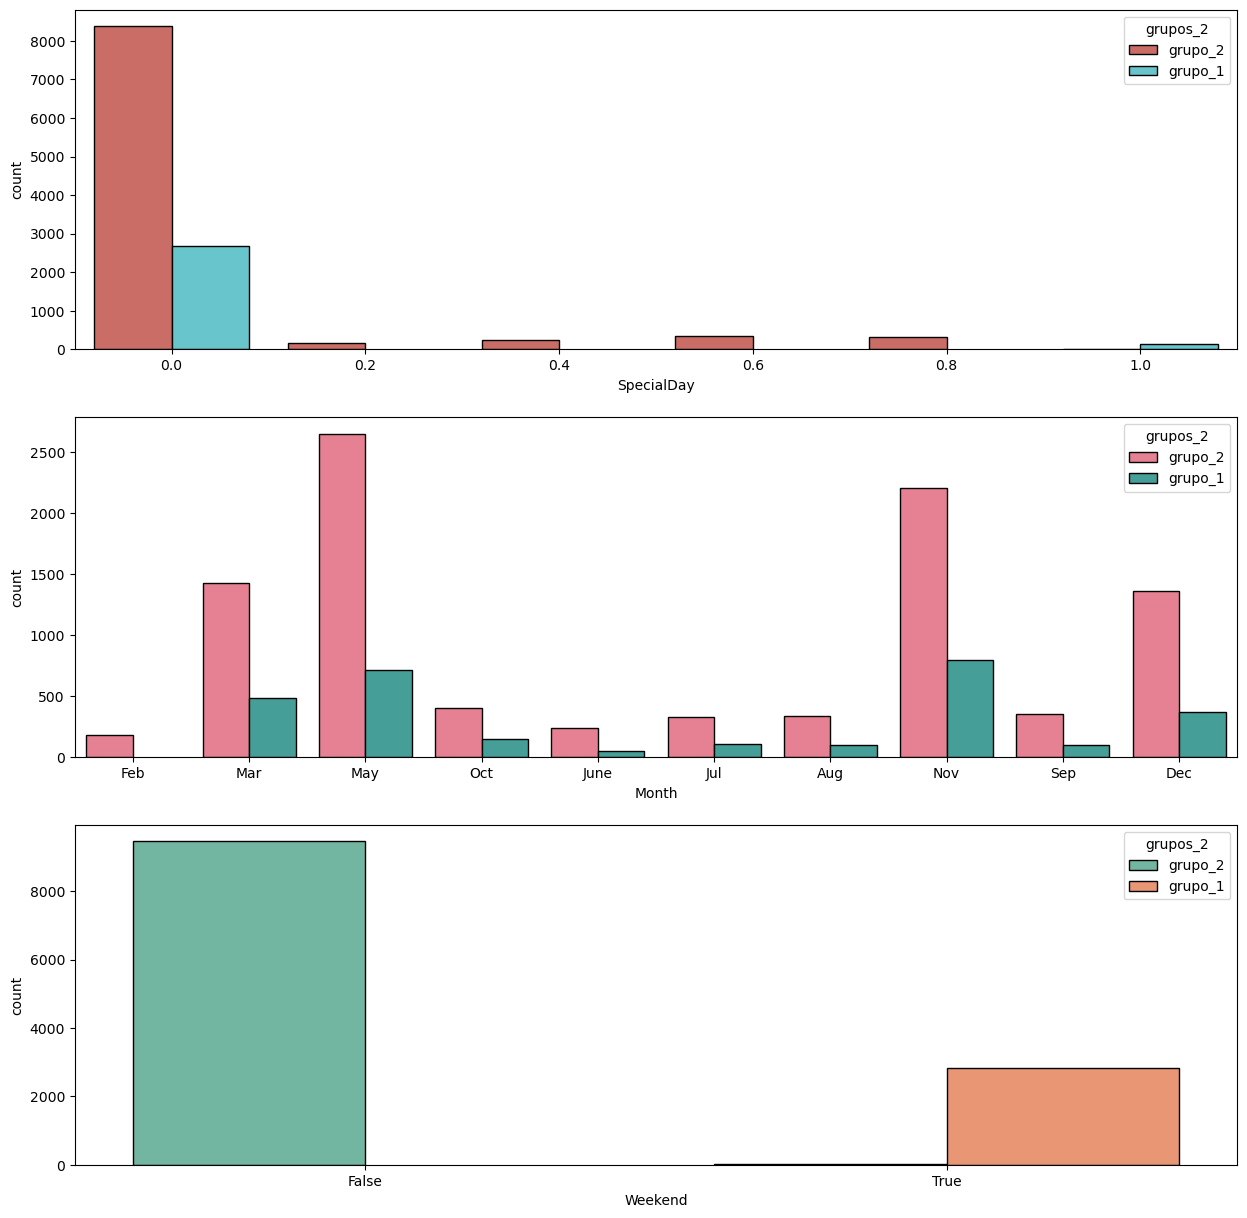

In [50]:
# Distribuição das variáveis
fig, axis = plt.subplots(3, 1, figsize=(15,15))

sns.countplot(data=df3, x = "SpecialDay", hue='grupos_2', palette ='hls', edgecolor='black', ax=axis[0])
sns.countplot(data=df3, x = "Month", hue='grupos_2', palette ='husl', edgecolor='black', ax=axis[1])
sns.countplot(data=df3, x = "Weekend", hue='grupos_2', palette ='Set2', edgecolor='black', ax=axis[2])

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

__Conclusão:__ Ao analisar 2 grupos distintos, identificou-se que o grupo_1 é o que apresenta maior probabilidade de realizar compras, uma vez que possui a maior taxa de Revenue = True e menores índices de Bounce Rate. Esses resultados indicam que os clientes pertencentes a esse grupo costumam acessar as páginas do site com maior frequência aos finais de semana. Essa conclusão se repete quando se expande a análise para 3 grupos distintos, reforçando a ideia de que aqueles que navegam no site durante os fins de semana são mais inclinados a realizar compras.